In [48]:
import trimesh
import neuroglancer_scripts
from meshparty import trimesh_io, skeleton
from scipy import spatial
KDTree = spatial.cKDTree
import nglui
from meshparty import mesh_filters
import more_itertools


import numpy as np
import pandas as pd

import math
pi = math.pi

In [49]:
# find the up vec for a given x z position

up_vec_dict = {'[0, 0]': np.array([[-0.08441962],
        [-0.99499665],
        [-0.05343209]]),
 '[0, 1]': np.array([[-0.10005934],
        [-0.99490884],
        [-0.01202171]]),
 '[1, 0]': np.array([[-0.07004   ],
        [-0.99654685],
        [-0.04459569]]),
 '[1, 1]': np.array([[-0.06623445],
        [-0.99758491],
        [-0.02091285]]),
 '[2, 0]': np.array([[-0.05101405],
        [-0.99634316],
        [-0.06854106]]),
 '[2, 1]': np.array([[-0.05697568],
        [-0.99829758],
        [-0.01247843]]),
 '[3, 0]': np.array([[-0.05861458],
        [-0.99570275],
        [-0.07169634]]),
 '[3, 1]': np.array([[-0.05276404],
        [-0.99536198],
        [-0.08043928]]),
 '[4, 0]': np.array([[-0.06981194],
        [-0.99213514],
        [-0.10389493]]),
 '[4, 1]': np.array([[-0.05538955],
        [-0.99523631],
        [-0.08022896]]),
 '[5, 0]': np.array([[-0.05357379],
        [-0.99145499],
        [-0.11894051]]),
 '[5, 1]': np.array([[-0.01186356],
        [-0.99573351],
        [-0.09150971]]),
 '[6, 0]': np.array([[-0.05883202],
        [-0.98997358],
        [-0.12841769]]),
 '[6, 1]': np.array([[ 3.94229021e-04],
        [-9.96570021e-01],
        [-8.27528753e-02]])}


x_ranges = [(570112.0, 675958.8571428572),
 (675958.8571428572, 781805.7142857143),
 (781805.7142857143, 887652.5714285714),
 (887652.5714285714, 993499.4285714286),
 (993499.4285714286, 1099346.2857142857),
 (1099346.2857142857, 1205193.1428571427),
 (1205193.1428571427, 1311040.0)]

z_ranges = [(748880.0, 842260.0), (842260.0, 935640.0)]


def find_up_vec(x_pos, z_pos):
    '''
    
    takes x and y position (nm) and returns the corresponding up vector 
    
    '''

    # find row/column combo in the grid of the xz spread of the dataset 
    xz_bin = []
    for i in range(len(x_ranges)):
        if x_ranges[i][0] <= x_pos <= x_ranges[i][1]:
            xz_bin.append(i)
        else:
            continue
    for ii in range(len(z_ranges)):
        if z_ranges[ii][0] <= z_pos <= z_ranges[ii][1]:
            xz_bin.append(ii)
        else:
            continue

    
    return up_vec_dict[str(xz_bin)]


In [88]:
np.array([[-0.06981194],
        [-0.99213514],
        [-0.10389493]]).shape

(3, 1)

In [50]:
np.array([[0],[-1],[0]]).reshape(3,1)

array([[ 0],
       [-1],
       [ 0]])

In [51]:
# functions to create the layer meshes 
def make_layer_poly(mesh_top, mesh_bottom, soma_pos, offset=1000, up_vec = np.array([0,-1,0])):
    # get the vec perp to the plane of up vec and x : 
    verts_top = get_mesh_line(mesh_top, soma_pos, up_vec)
    verts_bot = get_mesh_line(mesh_bottom, soma_pos, up_vec)
    print(len(verts_top))
    print(len(verts_bot))
    verts_top = verts_top[::-1,:] + np.array([0,offset,0])
    verts_bot = verts_bot - np.array([0,offset,0])
    poly_verts= np.concatenate([verts_top, verts_bot])
    return poly_verts


def get_mesh_line(mesh, soma_pos, up_vec = np.array([0,-1,0])):
    up_vec = up_vec.reshape((3,))
    uv_norm = np.cross(up_vec, np.array([1,0,0]).T)
    lines=trimesh.intersections.mesh_plane(mesh, uv_norm, soma_pos)
    lines_con = lines.reshape(lines.shape[0]*lines.shape[1],3)
    
    verts,inv = np.unique(lines_con, axis=0, return_inverse=True)
    lines=inv.reshape(len(inv)//2,2)
    
    tree = KDTree(verts)
    pairs = tree.query_pairs(1)
    for pair in pairs:
        lines[lines==pair[1]]=pair[0]
    
    sk=skeleton.Skeleton(verts,lines,root=np.argmin(verts[:,0]))
    sk=sk.apply_mask(mesh_filters.filter_largest_component(sk))
    
    cp = sk.cover_paths[0]
    verts = sk.vertices[cp]
    return verts

In [52]:
from neuroglancer_scripts.mesh import read_precomputed_mesh
mesh_dict={}
for filepath in ["layer_meshes/l23","layer_meshes/l4","layer_meshes/l5","layer_meshes/l6a","layer_meshes/l6b","layer_meshes/wm"]:
    print(filepath)
    with open(filepath,'rb') as fp:
        verts,faces = read_precomputed_mesh(fp)
    mesh = trimesh_io.Mesh(verts, faces)
    filename = filepath.split('/')[1]
    mesh_dict[filename]=mesh
    

layer_meshes/l23
layer_meshes/l4
layer_meshes/l5
layer_meshes/l6a
layer_meshes/l6b
layer_meshes/wm


In [53]:
pia_mesh = trimesh.load_mesh('layer_meshes/pia3.ply')
mesh_dict['pia'] = pia_mesh
mesh_dict['pia'] = trimesh_io.Mesh(mesh_dict['pia'].vertices * 1_000_000, mesh_dict['pia'].faces)

soma_pos = np.array([1148096.0, 623744.0, 826760.0])

In [54]:
up_vec = find_up_vec(x_pos = soma_pos[0], z_pos = soma_pos[2]).reshape(-1)


lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], soma_pos = soma_pos)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], soma_pos = soma_pos)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], soma_pos = soma_pos)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], soma_pos = soma_pos)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6abverts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], soma_pos = soma_pos)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6abverts]})

lay6bwmverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], soma_pos = soma_pos)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bwmverts]})


70
63
63
63
63
63
63
63
63
71
71
63


In [55]:
import caveclient 
client = caveclient.CAVEclient('minnie65_phase3_v1')
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['lay1', 'lay23', 'l4', 'l5', 'l6a', 'l6b']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df, lay23df, lay4df, lay5df, lay6adf, lay6bdf], return_as='html')

In [56]:
import caveclient
client = caveclient.CAVEclient('minnie65_phase3_v1')
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['l1']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df], return_as='html')

### Finding the norm to plane to cut mesh using my up vec
- find plane that passes through soma and my up vec
    - that could be any plan rotated about my up vec 
- find that plane that is closest to flat against x axis 
- how to do this - maximize cross product between flat plane norm and my up vec plane norm
- wouldn't it also work to find the plane that goes through my up vec, a vec parallel to x axis, and passes through soma?
- to do that maybe I can shift all coords so that soma is at origion, then shift back up 



- check if bounding box weused lines up with alex's mesh coverage


be comfortable running skeleton keys pipeline 
- run for the cells we already ran using nunos manually defined layer bounds, use my cut ^ of polygons
- should be pretty similar but probably not the same 
- run with docker image - forrest is curious if I can run his docker image that he has pushed to hub 
- F has scripts for creating the python taskqueues 
- I will change some of the parameters - like if I have a different skelton bucket 
- possible to run this locally, at least to test it out 
- generate polygon files for every cell 


In [57]:
# create a new normal vec to use in get_mesh_line
# 

In [58]:
# now I will need to find the normal to the plan that intersects this line and is paralell
# to the z plane 

# so first I can pass my up vec through the soma locaiton and find the intersection with 
# line at z = soma z location 
# find the cross product of these two vectors to get the normal to use in this line : 
#  lines=trimesh.intersections.mesh_plane(mesh, *normal here*, soma_pos)


In [59]:
# get the cross product between this ^ and 1,0,0
np.cross(up_vec.reshape(-1), np.array([[1],[0],[0]]).T)

array([[ 0.        , -0.11894051,  0.99145499]])

In [60]:
# create an example to run through skeleton keys 
# create folders that contain 10 labeled swcs 

In [61]:
#export GOOGLE_APPLICATION_CREDENTIALS = "/Users/emily.joyce/.cloudvolume/secrets/google-secret.json"

In [62]:
# create a function that will take in an swc, find the root location, then create a 
# polygon file 

# does not work
#pd.read_csv('gs://https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/axon_removed/scc_excitatory_csm_swc_relabel/864691135526058843.swc')

In [63]:
#import pandas as pd
#import gcsfs

#fs = gcsfs.GCSFileSystem(project='my-project')
#with fs.open('bucket/path.csv') as f:
#    df = pd.read_csv(f)

In [64]:
# ok so eventually I need to be able to do this. for now I will just export a test and 
# try to get that through everything and use the docker image 

In [65]:
# test cell is 864691135526058843

In [66]:
# so I need to find in soma table 
body_id = 864691135526058843

soma_df = client.materialize.query_table('nucleus_neuron_svm') 

In [67]:
soma_loc = soma_df[soma_df['pt_root_id'] == body_id]['pt_position'].iloc[0]*[4,4,40]
soma_loc

array([734912, 629824, 924440])

In [68]:
# ok great! now I can find the up vector 
up_vec = find_up_vec(soma_loc[0], soma_loc[2]).reshape(-1)
up_vec

array([-0.06623445, -0.99758491, -0.02091285])

In [69]:
# now I will view this state
lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_loc)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_loc)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_loc)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_loc)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6averts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_loc)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6averts]})

lay6bverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_loc)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bverts]})

54
63
63
63
63
63
63
63
63
71
71
63


In [70]:
img_layer, seg_layer = nglui.statebuilder.from_client(client)
point_mapper = nglui.statebuilder.PointMapper(point_column='pos')
sbs = []
for lay in ['lay1', 'lay23', 'l4', 'l5', 'l6a', 'l6b']:
    
    ann_layer = nglui.statebuilder.AnnotationLayerConfig(mapping_rules=[point_mapper], name=lay)
    sbs.append(nglui.statebuilder.StateBuilder([img_layer, seg_layer, ann_layer]))
sb  = nglui.statebuilder.ChainedStateBuilder(sbs)
sb.render_state([lay1df, lay23df, lay4df, lay5df, lay6adf, lay6bdf], return_as='html')

In [71]:
# yest this does indeed seem slanted. 
# OK! now I need to get this into the correct format. Here is an example
{"pia_path":{"name":"Pia",
             "path":[[880,1071],[928,1064],[979,1055],[1022,1049],[1071,1041],[1119,1033],[1167,1023],[1213,1021],[1261,1014],[1306,1011],[1357,1001],[1406,999],[1455,996],[1507,993],[1581,977],[1640,970],[1690,964],[1744,959],[1801,949],[1857,937],[1914,928],[1967,925],[2012,925],[2062,929],[2279,909],[2346,896],[2410,889],[2470,885],[2527,880],[2584,877],[2650,868],[2703,860],[2758,857],[2815,857],[2875,850],[2924,857],[3119,866],[3176,853],[3227,842],[3284,841],[3342,845],[3401,844],[3456,846],[3515,847],[3573,846],[3637,840],[3693,832],[3759,828],[3817,814],[3910,798],[4108,801],[4350,808]],
             "resolution":0.3603,
             "biospecimen_id":864691134674764538},
 "wm_path":{"name":"White Matter",
            "path":[[1003,3008],[1125,2999],[1224,2992],[1322,2992],[1429,2976],[1580,2976],[1731,2966],[1881,2957],[2032,2941],[2183,2919],[2333,2882],[2484,2872],[2635,2874],[2786,2859],[2936,2849],[3087,2824],[3238,2804],[3389,2787],[3539,2782],[3690,2787],[3841,2783],[3991,2783],[4142,2783],[4249,2801],[4372,2813],[4504,2825]],
            "resolution":0.3603,
            "biospecimen_id":864691134674764538},
 "soma_path":{"name":"Soma",
              "path":[[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]],
              "resolution":0.3603,
              "biospecimen_id":864691134674764538,
              "center":[656.1643075215098,1674.8709408825978]},
 "layer_polygons":[{"path":[[880,1085],[928,1078],[979,1069],[1022,1063],[1071,1055],[1119,1047],[1167,1037],[1213,1035],[1261,1028],[1306,1025],[1357,1015],[1406,1013],[1455,1009],[1507,1007],[1581,991],[1640,983],[1690,978],[1744,973],[1801,963],[1857,951],[1914,942],[1967,939],[2012,939],[2062,943],[2279,922],[2346,909],[2410,903],[2470,899],[2527,894],[2584,891],[2650,882],[2703,874],[2758,870],[2815,870],[2875,864],[2924,870],[3119,880],[3176,867],[3227,856],[3284,855],[3342,859],[3401,857],[3456,860],[3515,861],[3573,860],[3637,854],[3693,846],[3759,842],[3817,828],[3910,812],[4112,817],[4354,825],[4350,1055],[4127,1057],[3949,1070],[3832,1079],[3783,1088],[3590,1104],[3421,1101],[3312,1098],[3162,1101],[3019,1113],[2915,1118],[2813,1126],[2642,1132],[2481,1163],[2351,1172],[2260,1178],[2127,1185],[1979,1183],[1873,1185],[1774,1189],[1669,1208],[1537,1226],[1404,1241],[1259,1252],[1133,1246],[1061,1255],[980,1257],[887,1257],[880,1085]],
                    "name":"Layer1",
                    "resolution":0.3603},
                   {"path":[[4350,1069],[4127,1071],[3949,1084],[3832,1093],[3783,1102],[3590,1118],[3421,1115],[3312,1112],[3162,1115],[3019,1127],[2915,1131],[2813,1140],[2642,1146],[2481,1177],[2351,1186],[2260,1192],[2127,1199],[1979,1197],[1873,1199],[1774,1203],[1669,1222],[1537,1240],[1404,1255],[1259,1266],[1133,1260],[1061,1269],[980,1270],[892,1283],[910,1607],[1009,1595],[1139,1597],[1258,1587],[1429,1573],[1580,1573],[1731,1613],[1881,1579],[2032,1560],[2183,1545],[2333,1549],[2484,1528],[2635,1500],[2786,1418],[2936,1399],[3087,1426],[3238,1430],[3389,1385],[3539,1359],[3690,1370],[3841,1390],[3991,1390],[4142,1390],[4368,1378],[4350,1069]],
                    "name":"Layer2/3",
                    "resolution":0.3603},
                   {"path":[[4368,1392],[4142,1404],[3991,1404],[3841,1404],[3690,1384],[3539,1373],[3389,1399],[3238,1444],[3087,1440],[2936,1413],[2786,1432],[2635,1514],[2484,1542],[2333,1562],[2183,1559],[2032,1574],[1881,1593],[1731,1627],[1580,1587],[1429,1587],[1258,1600],[1139,1611],[1009,1609],[910,1621],[948,1972],[1037,1984],[1104,1978],[1187,1975],[1279,1965],[1429,1954],[1580,1954],[1731,1947],[1881,1937],[2032,1928],[2183,1918],[2333,1896],[2484,1893],[2635,1860],[2786,1843],[2936,1833],[3087,1789],[3238,1775],[3389,1760],[3539,1727],[3690,1699],[3841,1689],[3991,1689],[4142,1689],[4391,1679],[4368,1392]],
                    "name":"Layer4",
                    "resolution":0.3603},
                   {"path":[[4400,1711],[4142,1703],[3991,1703],[3841,1703],[3690,1713],[3539,1741],[3389,1774],[3238,1789],[3087,1803],[2936,1847],[2786,1857],[2635,1873],[2484,1906],[2333,1910],[2183,1932],[2032,1942],[1881,1951],[1731,1961],[1580,1968],[1429,1968],[1279,1979],[1187,1989],[1104,1992],[1037,1998],[948,1986],[972,2489],[1104,2476],[1208,2470],[1316,2458],[1429,2444],[1580,2444],[1731,2392],[1881,2341],[2032,2317],[2183,2327],[2333,2339],[2484,2316],[2635,2293],[2786,2271],[2936,2256],[3087,2298],[3238,2217],[3389,2178],[3539,2183],[3690,2183],[3841,2197],[3991,2197],[4142,2197],[4436,2193],[4400,1711]],
                    "name":"Layer5",
                    "resolution":0.3603},
                   {"path":[[4443,2226],[4142,2211],[3991,2211],[3841,2211],[3690,2196],[3539,2196],[3389,2192],[3238,2231],[3087,2312],[2936,2270],[2786,2285],[2635,2307],[2484,2330],[2333,2353],[2183,2341],[2032,2330],[1881,2355],[1731,2406],[1580,2458],[1429,2458],[1316,2472],[1208,2484],[1104,2490],[972,2502],[984,2888],[1046,2882],[1141,2879],[1242,2854],[1368,2867],[1466,2870],[1573,2851],[1690,2839],[1783,2816],[1846,2811],[1908,2811],[1971,2816],[2034,2816],[2096,2805],[2159,2784],[2222,2773],[2284,2766],[2347,2757],[2410,2756],[2472,2752],[2535,2745],[2598,2740],[2660,2732],[2723,2716],[2786,2700],[2848,2680],[2911,2673],[2974,2661],[3036,2651],[3099,2638],[3162,2649],[3224,2658],[3287,2660],[3350,2658],[3412,2649],[3475,2642],[3538,2640],[3600,2641],[3721,2654],[3850,2657],[3976,2675],[4093,2672],[4237,2663],[4363,2657],[4495,2650],[4443,2226]],
                    "name":"Layer6a",
                    "resolution":0.3603},
                   {"path":[[4504,2689],[4363,2671],[4237,2677],[4093,2686],[3976,2689],[3850,2671],[3721,2668],[3600,2655],[3538,2654],[3475,2655],[3412,2663],[3350,2671],[3287,2674],[3224,2672],[3162,2663],[3099,2652],[3036,2665],[2974,2675],[2911,2687],[2848,2694],[2786,2714],[2723,2730],[2660,2746],[2598,2754],[2535,2758],[2472,2765],[2410,2769],[2347,2771],[2284,2780],[2222,2787],[2159,2798],[2096,2819],[2034,2830],[1971,2830],[1908,2825],[1846,2825],[1783,2830],[1690,2853],[1573,2865],[1466,2884],[1368,2880],[1242,2868],[1141,2893],[1046,2896],[984,2902],[1003,2994],[1125,2985],[1224,2978],[1322,2978],[1429,2962],[1580,2962],[1731,2953],[1881,2943],[2032,2927],[2183,2905],[2333,2868],[2484,2858],[2635,2860],[2786,2845],[2936,2835],[3087,2810],[3238,2790],[3389,2773],[3539,2769],[3690,2773],[3841,2769],[3991,2769],[4142,2769],[4249,2787],[4372,2799],[4504,2812],[4504,2689]],
                    "name":"Layer6b",
                    "resolution":0.3603}]}






{'pia_path': {'name': 'Pia',
  'path': [[880, 1071],
   [928, 1064],
   [979, 1055],
   [1022, 1049],
   [1071, 1041],
   [1119, 1033],
   [1167, 1023],
   [1213, 1021],
   [1261, 1014],
   [1306, 1011],
   [1357, 1001],
   [1406, 999],
   [1455, 996],
   [1507, 993],
   [1581, 977],
   [1640, 970],
   [1690, 964],
   [1744, 959],
   [1801, 949],
   [1857, 937],
   [1914, 928],
   [1967, 925],
   [2012, 925],
   [2062, 929],
   [2279, 909],
   [2346, 896],
   [2410, 889],
   [2470, 885],
   [2527, 880],
   [2584, 877],
   [2650, 868],
   [2703, 860],
   [2758, 857],
   [2815, 857],
   [2875, 850],
   [2924, 857],
   [3119, 866],
   [3176, 853],
   [3227, 842],
   [3284, 841],
   [3342, 845],
   [3401, 844],
   [3456, 846],
   [3515, 847],
   [3573, 846],
   [3637, 840],
   [3693, 832],
   [3759, 828],
   [3817, 814],
   [3910, 798],
   [4108, 801],
   [4350, 808]],
  'resolution': 0.3603,
  'biospecimen_id': 864691134674764538},
 'wm_path': {'name': 'White Matter',
  'path': [[1003, 30

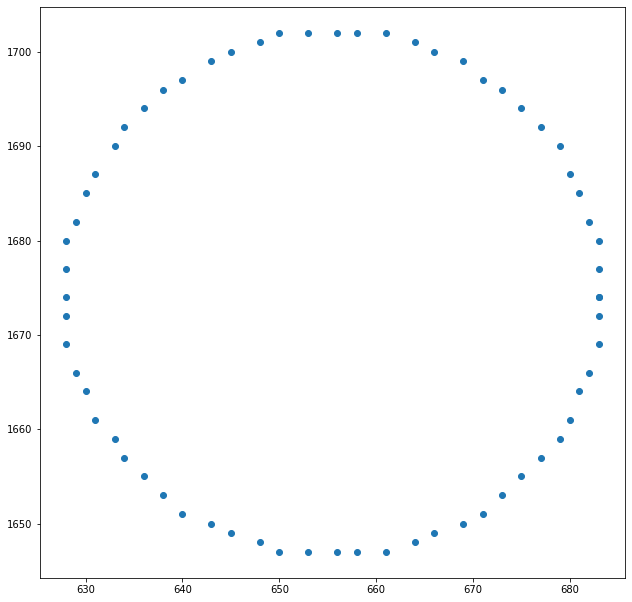

In [72]:
# need to calculate soma path 
# let me map out the example soma path

from matplotlib import pyplot

fig, ax = pyplot.subplots()
fig.set_size_inches(10.5, 10.5)
points = np.array([[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]])
ax.scatter(x = points[:,0], y = points[:,1])

In [73]:
points[:,0].max()

683

In [74]:
# get center of circle
center = np.array([points[:,0].mean(), points[:,1].mean()])
center

array([ 656.03076923, 1674.38461538])

In [75]:
radius = points[:,0].max() - center[0]
radius

26.969230769230762

In [76]:
# I will use 25 for this example and discuss with F on monday 

In [77]:
# how many points?
len(points)

65

In [78]:
# make function to get soma polygon
def calculate_soma_poly(soma_loc, n, r):
    '''
    returns n number of points evenly spaced around radius r circle from soma location
    
    '''
    
    return np.array([(math.cos(2*pi/n*x)*r + soma_loc[0], math.sin(2*pi/n*x)*r + soma_loc[2]) for x in range(0,n+1)])
    
    
    

In [98]:
points2 = calculate_soma_poly(soma_loc, 65, 25)
points2.shape

(66, 2)

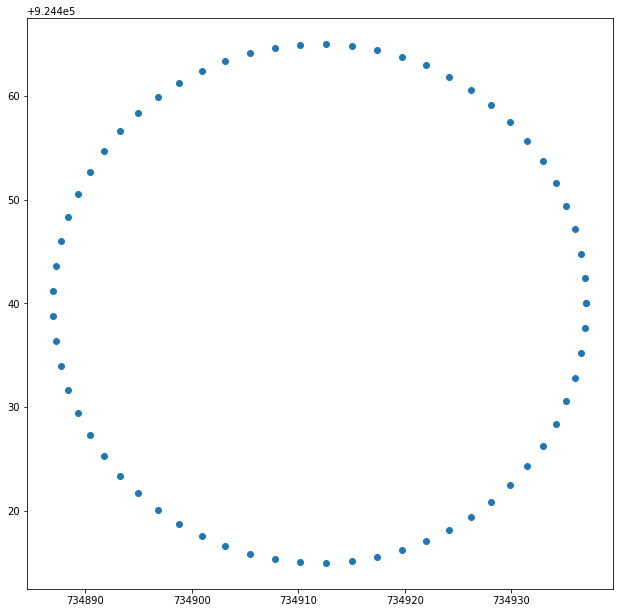

In [80]:

fig, ax = pyplot.subplots()
fig.set_size_inches(10.5, 10.5)
ax.scatter(x = points2[:,0], y = points2[:,1])

In [81]:
# now I will view this state
lay1verts = make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_loc)
lay1df = pd.DataFrame({'pos':[k/[4,4,40] for k in lay1verts]})

lay23verts =make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_loc)
lay23df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay23verts]})

lay4verts =make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_loc)
lay4df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay4verts]})

lay5verts =make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_loc)
lay5df=pd.DataFrame({'pos':[k/[4,4,40] for k in lay5verts]})

lay6averts =make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_loc)
lay6adf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6averts]})

lay6bverts =make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_loc)
lay6bdf=pd.DataFrame({'pos':[k/[4,4,40] for k in lay6bverts]})

54
63
63
63
63
63
63
63
63
71
71
63


In [96]:
np.array([1,2,3]).shape

(3,)

In [82]:
def make_poly_file(soma_pos, specimen_id, n_soma_circ_pts = 65, soma_rad = 25, res = 0.3603):
    
    '''
    soma_pos must be in nm nad roughly between these values:
    x: 570112-1311040
    z: 748880-935640
    
    
    '''
    # create teh empty poly dict to be filled
    poly_dict = {}
    
    # create empty sub dicts/lists which will be filled then entered into poly dict
    pia_dict = {}
    wm_dict = {}
    soma_dict = {}
    layer_polygons_list = []
    # now create the layer polygons subdicts
    layer1_dict = {}
    layer2_3_dict = {}
    layer4_dict = {}
    layer5_dict = {}
    layer6a_dict = {}
    layer6b_dict = {}

    # find the up vector 
    up_vec = np.array(find_up_vec(soma_pos[0], soma_pos[2]))
    # calculate layer verts
    
    pia_verts = np.around(get_mesh_line(mesh_dict['pia'], soma_pos, up_vec=up_vec)[:,0:2]/[1000*res,1000*res])
    lay1verts = np.around(make_layer_poly(mesh_dict['pia'], mesh_dict['l23'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay23verts = np.around(make_layer_poly(mesh_dict['l23'], mesh_dict['l4'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay4verts = np.around(make_layer_poly(mesh_dict['l4'], mesh_dict['l5'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay5verts = np.around(make_layer_poly(mesh_dict['l5'], mesh_dict['l6a'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay6averts = np.around(make_layer_poly(mesh_dict['l6a'], mesh_dict['l6b'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    lay6bverts = np.around(make_layer_poly(mesh_dict['l6b'], mesh_dict['wm'], up_vec=up_vec, soma_pos = soma_pos)[:,0:2]/[1000*res,1000*res])
    wm_verts = np.around(get_mesh_line(mesh_dict['wm'], soma_pos, up_vec=up_vec)[:,0:2]/[1000*res,1000*res])
    
    # fill out pia dict
    pia_dict['name'] = "Pia"
    pia_dict['path'] = pia_verts.tolist()
    pia_dict['resolution'] = res
    pia_dict['biospecimen_id'] = specimen_id
    # insert pia dict into main poly dict 
    poly_dict['pia_path'] = pia_dict
    
    # fill out white matter dict 
    wm_dict['name'] = "White Matter"
    wm_dict['path'] = wm_verts.tolist()
    wm_dict['resolution'] = res
    wm_dict['biospecimen_id'] = specimen_id
    # insert wm_dict to poly_dict
    poly_dict['wm_path'] = pia_dict
    
    # now do the soma path 
    soma_dict['name'] = "Soma"
    soma_dict['path'] = np.around(calculate_soma_poly(soma_loc, 65, 25)/[1000*res,1000*res]).tolist()
    soma_dict['resolution'] = res
    soma_dict['biospecimen_id'] = specimen_id 
    soma_dict['center'] =  [soma_pos[0], soma_pos[2]]
    # insert to larger ditc
    poly_dict['soma_path'] = soma_dict
    
    # now fill out the larger layer_polygons_dict
    # layer by layer 
    layer1_dict['path'] = lay1verts.tolist()
    layer1_dict['name'] = 'Layer1'
    layer1_dict['resolution'] = res
    
    layer2_3_dict['path'] = lay23verts.tolist()
    layer2_3_dict['name'] = 'Layer2/3'
    layer2_3_dict['resolution'] = res
    
    layer4_dict['path'] = lay4verts.tolist()
    layer4_dict['name'] = 'Layer4'
    layer4_dict['resolution'] = res

    layer5_dict['path'] = lay5verts.tolist()
    layer5_dict['name'] = 'Layer5'
    layer5_dict['resolution'] = res

    layer6a_dict['path'] = lay6averts.tolist()
    layer6a_dict['name'] = 'Layer6a'
    layer6a_dict['resolution'] = res
    
    layer6b_dict['path'] = lay6bverts.tolist()
    layer6b_dict['name'] = 'Layer6b'
    layer6b_dict['resolution'] = res
    
    #insert all of the above into layer_polygons_list
    layer_polygons_list.append(layer1_dict)
    layer_polygons_list.append(layer2_3_dict)
    layer_polygons_list.append(layer4_dict)
    layer_polygons_list.append(layer5_dict)
    layer_polygons_list.append(layer6a_dict)
    layer_polygons_list.append(layer6b_dict)

    # insert the layer_polygons_list into poly_dict
    poly_dict['layer_polygons'] = layer_polygons_list

    
    return poly_dict
    
    
    
    


In [83]:
soma_loc
up_vec = find_up_vec(soma_loc[0], soma_loc[2])
body_id = 864691135526058843
test_poly = make_poly_file(soma_pos = np.array([1148096.,  623744.,  826760.]), 
               specimen_id = 864691135526058843, n_soma_circ_pts = 65, 
               soma_rad = 25, res = 0.3603)
test_poly

66
63
63
63
63
65
65
63
63
71
71
63


{'pia_path': {'name': 'Pia',
  'path': [[4105.0, 878.0],
   [4080.0, 895.0],
   [4061.0, 890.0],
   [3958.0, 890.0],
   [3917.0, 883.0],
   [3882.0, 886.0],
   [3744.0, 886.0],
   [3726.0, 886.0],
   [3691.0, 891.0],
   [3609.0, 899.0],
   [3537.0, 901.0],
   [3493.0, 898.0],
   [3475.0, 907.0],
   [3430.0, 910.0],
   [3381.0, 904.0],
   [3335.0, 898.0],
   [3297.0, 901.0],
   [3200.0, 900.0],
   [3146.0, 903.0],
   [3083.0, 902.0],
   [3043.0, 894.0],
   [2980.0, 888.0],
   [2951.0, 884.0],
   [2919.0, 888.0],
   [2852.0, 884.0],
   [2816.0, 888.0],
   [2770.0, 889.0],
   [2711.0, 894.0],
   [2602.0, 905.0],
   [2555.0, 916.0],
   [2510.0, 929.0],
   [2480.0, 936.0],
   [2407.0, 953.0],
   [2390.0, 955.0],
   [2287.0, 984.0],
   [2279.0, 984.0],
   [2272.0, 985.0],
   [2264.0, 987.0],
   [2146.0, 993.0],
   [2138.0, 993.0],
   [2021.0, 997.0],
   [2018.0, 997.0],
   [2003.0, 997.0],
   [1903.0, 994.0],
   [1750.0, 996.0],
   [1744.0, 995.0],
   [1731.0, 996.0],
   [1714.0, 999.0],
   

In [84]:
# Here is the comparison poly

comp_poly = {"pia_path":{"name":"Pia",
             "path":[[880,1071],[928,1064],[979,1055],[1022,1049],[1071,1041],[1119,1033],[1167,1023],[1213,1021],[1261,1014],[1306,1011],[1357,1001],[1406,999],[1455,996],[1507,993],[1581,977],[1640,970],[1690,964],[1744,959],[1801,949],[1857,937],[1914,928],[1967,925],[2012,925],[2062,929],[2279,909],[2346,896],[2410,889],[2470,885],[2527,880],[2584,877],[2650,868],[2703,860],[2758,857],[2815,857],[2875,850],[2924,857],[3119,866],[3176,853],[3227,842],[3284,841],[3342,845],[3401,844],[3456,846],[3515,847],[3573,846],[3637,840],[3693,832],[3759,828],[3817,814],[3910,798],[4108,801],[4350,808]],
             "resolution":0.3603,
             "biospecimen_id":864691134674764538},
 "wm_path":{"name":"White Matter",
            "path":[[1003,3008],[1125,2999],[1224,2992],[1322,2992],[1429,2976],[1580,2976],[1731,2966],[1881,2957],[2032,2941],[2183,2919],[2333,2882],[2484,2872],[2635,2874],[2786,2859],[2936,2849],[3087,2824],[3238,2804],[3389,2787],[3539,2782],[3690,2787],[3841,2783],[3991,2783],[4142,2783],[4249,2801],[4372,2813],[4504,2825]],
            "resolution":0.3603,
            "biospecimen_id":864691134674764538},
 "soma_path":{"name":"Soma",
              "path":[[683,1674],[683,1677],[683,1680],[682,1682],[681,1685],[680,1687],[679,1690],[677,1692],[675,1694],[673,1696],[671,1697],[669,1699],[666,1700],[664,1701],[661,1702],[658,1702],[656,1702],[653,1702],[650,1702],[648,1701],[645,1700],[643,1699],[640,1697],[638,1696],[636,1694],[634,1692],[633,1690],[631,1687],[630,1685],[629,1682],[628,1680],[628,1677],[628,1674],[628,1672],[628,1669],[629,1666],[630,1664],[631,1661],[633,1659],[634,1657],[636,1655],[638,1653],[640,1651],[643,1650],[645,1649],[648,1648],[650,1647],[653,1647],[656,1647],[658,1647],[661,1647],[664,1648],[666,1649],[669,1650],[671,1651],[673,1653],[675,1655],[677,1657],[679,1659],[680,1661],[681,1664],[682,1666],[683,1669],[683,1672],[683,1674]],
              "resolution":0.3603,
              "biospecimen_id":864691134674764538,
              "center":[656.1643075215098,1674.8709408825978]},
 "layer_polygons":[{"path":[[880,1085],[928,1078],[979,1069],[1022,1063],[1071,1055],[1119,1047],[1167,1037],[1213,1035],[1261,1028],[1306,1025],[1357,1015],[1406,1013],[1455,1009],[1507,1007],[1581,991],[1640,983],[1690,978],[1744,973],[1801,963],[1857,951],[1914,942],[1967,939],[2012,939],[2062,943],[2279,922],[2346,909],[2410,903],[2470,899],[2527,894],[2584,891],[2650,882],[2703,874],[2758,870],[2815,870],[2875,864],[2924,870],[3119,880],[3176,867],[3227,856],[3284,855],[3342,859],[3401,857],[3456,860],[3515,861],[3573,860],[3637,854],[3693,846],[3759,842],[3817,828],[3910,812],[4112,817],[4354,825],[4350,1055],[4127,1057],[3949,1070],[3832,1079],[3783,1088],[3590,1104],[3421,1101],[3312,1098],[3162,1101],[3019,1113],[2915,1118],[2813,1126],[2642,1132],[2481,1163],[2351,1172],[2260,1178],[2127,1185],[1979,1183],[1873,1185],[1774,1189],[1669,1208],[1537,1226],[1404,1241],[1259,1252],[1133,1246],[1061,1255],[980,1257],[887,1257],[880,1085]],
                    "name":"Layer1",
                    "resolution":0.3603},
                   {"path":[[4350,1069],[4127,1071],[3949,1084],[3832,1093],[3783,1102],[3590,1118],[3421,1115],[3312,1112],[3162,1115],[3019,1127],[2915,1131],[2813,1140],[2642,1146],[2481,1177],[2351,1186],[2260,1192],[2127,1199],[1979,1197],[1873,1199],[1774,1203],[1669,1222],[1537,1240],[1404,1255],[1259,1266],[1133,1260],[1061,1269],[980,1270],[892,1283],[910,1607],[1009,1595],[1139,1597],[1258,1587],[1429,1573],[1580,1573],[1731,1613],[1881,1579],[2032,1560],[2183,1545],[2333,1549],[2484,1528],[2635,1500],[2786,1418],[2936,1399],[3087,1426],[3238,1430],[3389,1385],[3539,1359],[3690,1370],[3841,1390],[3991,1390],[4142,1390],[4368,1378],[4350,1069]],
                    "name":"Layer2/3",
                    "resolution":0.3603},
                   {"path":[[4368,1392],[4142,1404],[3991,1404],[3841,1404],[3690,1384],[3539,1373],[3389,1399],[3238,1444],[3087,1440],[2936,1413],[2786,1432],[2635,1514],[2484,1542],[2333,1562],[2183,1559],[2032,1574],[1881,1593],[1731,1627],[1580,1587],[1429,1587],[1258,1600],[1139,1611],[1009,1609],[910,1621],[948,1972],[1037,1984],[1104,1978],[1187,1975],[1279,1965],[1429,1954],[1580,1954],[1731,1947],[1881,1937],[2032,1928],[2183,1918],[2333,1896],[2484,1893],[2635,1860],[2786,1843],[2936,1833],[3087,1789],[3238,1775],[3389,1760],[3539,1727],[3690,1699],[3841,1689],[3991,1689],[4142,1689],[4391,1679],[4368,1392]],
                    "name":"Layer4",
                    "resolution":0.3603},
                   {"path":[[4400,1711],[4142,1703],[3991,1703],[3841,1703],[3690,1713],[3539,1741],[3389,1774],[3238,1789],[3087,1803],[2936,1847],[2786,1857],[2635,1873],[2484,1906],[2333,1910],[2183,1932],[2032,1942],[1881,1951],[1731,1961],[1580,1968],[1429,1968],[1279,1979],[1187,1989],[1104,1992],[1037,1998],[948,1986],[972,2489],[1104,2476],[1208,2470],[1316,2458],[1429,2444],[1580,2444],[1731,2392],[1881,2341],[2032,2317],[2183,2327],[2333,2339],[2484,2316],[2635,2293],[2786,2271],[2936,2256],[3087,2298],[3238,2217],[3389,2178],[3539,2183],[3690,2183],[3841,2197],[3991,2197],[4142,2197],[4436,2193],[4400,1711]],
                    "name":"Layer5",
                    "resolution":0.3603},
                   {"path":[[4443,2226],[4142,2211],[3991,2211],[3841,2211],[3690,2196],[3539,2196],[3389,2192],[3238,2231],[3087,2312],[2936,2270],[2786,2285],[2635,2307],[2484,2330],[2333,2353],[2183,2341],[2032,2330],[1881,2355],[1731,2406],[1580,2458],[1429,2458],[1316,2472],[1208,2484],[1104,2490],[972,2502],[984,2888],[1046,2882],[1141,2879],[1242,2854],[1368,2867],[1466,2870],[1573,2851],[1690,2839],[1783,2816],[1846,2811],[1908,2811],[1971,2816],[2034,2816],[2096,2805],[2159,2784],[2222,2773],[2284,2766],[2347,2757],[2410,2756],[2472,2752],[2535,2745],[2598,2740],[2660,2732],[2723,2716],[2786,2700],[2848,2680],[2911,2673],[2974,2661],[3036,2651],[3099,2638],[3162,2649],[3224,2658],[3287,2660],[3350,2658],[3412,2649],[3475,2642],[3538,2640],[3600,2641],[3721,2654],[3850,2657],[3976,2675],[4093,2672],[4237,2663],[4363,2657],[4495,2650],[4443,2226]],
                    "name":"Layer6a",
                    "resolution":0.3603},
                   {"path":[[4504,2689],[4363,2671],[4237,2677],[4093,2686],[3976,2689],[3850,2671],[3721,2668],[3600,2655],[3538,2654],[3475,2655],[3412,2663],[3350,2671],[3287,2674],[3224,2672],[3162,2663],[3099,2652],[3036,2665],[2974,2675],[2911,2687],[2848,2694],[2786,2714],[2723,2730],[2660,2746],[2598,2754],[2535,2758],[2472,2765],[2410,2769],[2347,2771],[2284,2780],[2222,2787],[2159,2798],[2096,2819],[2034,2830],[1971,2830],[1908,2825],[1846,2825],[1783,2830],[1690,2853],[1573,2865],[1466,2884],[1368,2880],[1242,2868],[1141,2893],[1046,2896],[984,2902],[1003,2994],[1125,2985],[1224,2978],[1322,2978],[1429,2962],[1580,2962],[1731,2953],[1881,2943],[2032,2927],[2183,2905],[2333,2868],[2484,2858],[2635,2860],[2786,2845],[2936,2835],[3087,2810],[3238,2790],[3389,2773],[3539,2769],[3690,2773],[3841,2769],[3991,2769],[4142,2769],[4249,2787],[4372,2799],[4504,2812],[4504,2689]],
                    "name":"Layer6b",
                    "resolution":0.3603}]}



In [85]:
test_poly.keys() == comp_poly.keys()

True

In [86]:
# export as json 

import json

f = open("864691135526058843_files/864691135526058843_poly.json", "w")
json.dump(test_poly, f)
f.close()

In [47]:
# import the up_vecs json as a dict


with open('/Users/emily.joyce/Work/Repos/code_review/skeleton_keys_files/skeleton_keys_excitatory_features/polygon_creation/up_vecs.json') as json_file:
    data = json.load(json_file)
data

{'[0, 0]': [[-0.08441962], [-0.99499665], [-0.05343209]],
 '[0, 1]': [[-0.10005934], [-0.99490884], [-0.01202171]],
 '[1, 0]': [[-0.07004], [-0.99654685], [-0.04459569]],
 '[1, 1]': [[-0.06623445], [-0.99758491], [-0.02091285]],
 '[2, 0]': [[-0.05101405], [-0.99634316], [-0.06854106]],
 '[2, 1]': [[-0.05697568], [-0.99829758], [-0.01247843]],
 '[3, 0]': [[-0.05861458], [-0.99570275], [-0.07169634]],
 '[3, 1]': [[-0.05276404], [-0.99536198], [-0.08043928]],
 '[4, 0]': [[-0.06981194], [-0.99213514], [-0.10389493]],
 '[4, 1]': [[-0.05538955], [-0.99523631], [-0.08022896]],
 '[5, 0]': [[-0.05357379], [-0.99145499], [-0.11894051]],
 '[5, 1]': [[-0.01186356], [-0.99573351], [-0.09150971]],
 '[6, 0]': [[-0.05883202], [-0.98997358], [-0.12841769]],
 '[6, 1]': [[0.000394229021], [-0.996570021], [-0.0827528753]]}

In [104]:
# now I am putting all these files into a .py file and testing the functions below.
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
import polygon_creation


In [106]:
polygon_creation.find_up_vec(x_pos = soma_pos[0], z_pos = soma_pos[2])


[[-0.05357379], [-0.99145499], [-0.11894051]]

In [131]:
res = .3603
[1000*res,1000*res]
points2 = polygon_creation.calculate_soma_poly(soma_loc, 65, 25000)
points2/[1000*res,1000*res]

array([[2109.10907577, 2565.75076325],
       [2108.78515367, 2572.44753823],
       [2107.81641175, 2579.08178722],
       [2106.21189489, 2585.59156803],
       [2103.98658402, 2591.91610059],
       [2101.16125629, 2597.99633445],
       [2097.76229101, 2603.77550009],
       [2093.8214234 , 2609.19963902],
       [2089.37544829, 2614.2181075 ],
       [2084.46587654, 2618.78404944],
       [2079.13854751, 2622.85483388],
       [2073.44320103, 2626.392453  ],
       [2067.43301301, 2629.363877  ],
       [2061.16409897, 2631.7413625 ],
       [2054.69499006, 2633.50271155],
       [2048.08608661, 2634.63147891],
       [2041.39909417, 2635.1171256 ],
       [2034.69644739, 2634.95511724],
       [2028.04072708, 2634.14696648],
       [2021.4940759 , 2632.7002188 ],
       [2015.11761816, 2630.62838209],
       [2008.97088915, 2627.95080053],
       [2003.1112792 , 2624.69247399],
       [1997.59349793, 2620.88382457],
       [1992.46906336, 2616.56041261],
       [1987.78582097, 26

In [145]:
test_poly = polygon_creation.make_poly_file(soma_pos = np.array([1148096.,  623744.,  826760.]), 
               specimen_id = 864691135526058843, n_soma_circ_pts = 65, 
               soma_rad = 2500, res = 0.3603)

In [146]:
def plot_layer_polygon(ax, surfaces_and_paths):
    pia_surface = surfaces_and_paths["pia_path"]
    wm_surface = surfaces_and_paths["wm_path"]
    soma_drawing = surfaces_and_paths["soma_path"]
    layer_polygons = surfaces_and_paths["layer_polygons"]

    path = np.array(pia_surface["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    path = np.array(wm_surface["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    path = np.array(soma_drawing["path"]) * pia_surface["resolution"]
    ax.plot(path[:, 0], path[:, 1])
    for poly in layer_polygons:
        path = np.array(poly["path"]) * pia_surface["resolution"]
        ax.plot(path[:, 0], path[:, 1])

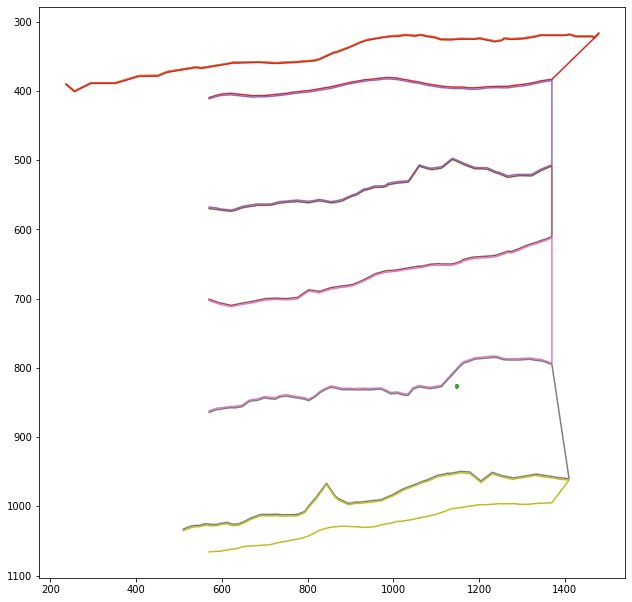

In [148]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)
#plt.xlim([3180.0, 3196.0])
#plt.ylim([2295.0, 2295.0])
ax.invert_yaxis()
plot_layer_polygon(ax, test_poly)